In [1]:
import discord
import random
import os
import asyncio

import pandas as pd
import requests

#########################

import pandas as pd
import glob
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import pandas as pd
import numpy as np

def has_consecutive_duplicates(lst):
    return any(lst[i] == lst[i+1] for i in range(len(lst)-1))

def get_phase(over):
    if over <= 6:
        return 'P'
    elif over <= 15:
        return 'M'
    else:
        return 'D'
    
def generate_bowling_order(bowler_dict, max_overs=4):
    from collections import Counter, defaultdict
    import random

    # Phase-wise bowler allocation
    phase_bowlers = defaultdict(list)
    for bowler, phases in bowler_dict.items():
        for p in phases:
            phase_bowlers[p].append(bowler)

    # Assigning ranks based on bowler_dict order
    bowler_ranks = {bowler: rank for rank, bowler in enumerate(bowler_dict.keys(), start=1)}
    #print(bowler_ranks)

    def can_bowl(bowler, count, phase, pp_tracker, middle_tracker):
        if count[bowler] >= max_overs:
            return False
        if phase == 'P' and bowler in all_phase_bowlers and pp_tracker[bowler] >= 2:
            return False
        if phase == 'M' and bowler in all_phase_bowlers and middle_tracker[bowler] >= 1:
            return False
        return True

    sequence = [None] * 20
    count = Counter()
    pp_tracker = Counter()
    middle_tracker = Counter()

    all_phase_bowlers = [b for b, phases in bowler_dict.items() if 'P' in phases and 'M' in phases and 'D' in phases]

    top_p_bowlers = [b for b in bowler_dict if 'P' in bowler_dict[b]]
    top_p_bowlers.sort(key=lambda bowler: bowler_dict[bowler].count('P'), reverse=True)

    sequence[0], sequence[1] = top_p_bowlers[0], top_p_bowlers[1]
    count[sequence[0]] += 1
    count[sequence[1]] += 1
    if sequence[0] in all_phase_bowlers:
        pp_tracker[sequence[0]] += 1
    if sequence[1] in all_phase_bowlers:
        pp_tracker[sequence[1]] += 1

    prev_bowler = sequence[1]
    for over in range(2, 20):
        phase = get_phase(over + 1)
        eligible = [b for b in phase_bowlers[phase] if b != prev_bowler and can_bowl(b, count, phase, pp_tracker, middle_tracker)]
        primary = [b for b in eligible if bowler_ranks[b] <= 6]
        backup = [b for b in eligible if bowler_ranks[b] > 6]
        available_bowlers = primary or backup

        if not available_bowlers:
            #print(sequence)
            raise RuntimeError(f"No valid bowlers available for over {over + 1}")

        chosen_bowler = random.choice(available_bowlers)
        sequence[over] = chosen_bowler
        count[chosen_bowler] += 1
        if phase == 'P' and chosen_bowler in all_phase_bowlers:
            pp_tracker[chosen_bowler] += 1
        if phase == 'M' and chosen_bowler in all_phase_bowlers:
            middle_tracker[chosen_bowler] += 1

        prev_bowler = chosen_bowler

    return sequence


def func_1(df):
    # Drop duplicates early on
    df = df.drop_duplicates()

    # Columns to replace NaNs
    df[['wides', 'noballs', 'byes', 'legbyes']] = df[['wides', 'noballs', 'byes', 'legbyes']].fillna(0)
    df[['wicket_type', 'player_dismissed']] = df[['wicket_type', 'player_dismissed']].fillna('')

    # Convert columns to string type where required
    cols_to_string = ['batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler', 'wicket_type', 'player_dismissed']
    df[cols_to_string] = df[cols_to_string].astype(str)

    # Sort once for ease of cumulative calculations
    df = df.sort_values(by=['start_date', 'match_id', 'innings', 'ball']).reset_index(drop=True)

    # Calculate legality and bowler wicket conditions
    df['legality'] = (df['wides'] + df['noballs']) == 0
    df['bowler_wicket'] = df['wicket_type'].isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket', 'out'])

    # Flagging and categorizing runs
    df['islegal'] = df['legality'].astype(int)
    df['isDotforBatter'] = (df['runs_off_bat'] == 0).astype(int)
    df['isOne'] = (df['runs_off_bat'] == 1).astype(int)
    df['isTwo'] = (df['runs_off_bat'] == 2).astype(int)
    df['isThree'] = (df['runs_off_bat'] == 3).astype(int)
    df['isStrikeRotation'] = df['runs_off_bat'].isin([1, 2, 3, 5, 7]).astype(int)
    df['isFour'] = (df['runs_off_bat'] == 4).astype(int)
    df['isSix'] = (df['runs_off_bat'] == 6).astype(int)
    df['isBowlerWicket'] = df['bowler_wicket'].astype(int)
    df['is_striker_Out'] = (df['striker'] == df['player_dismissed']).astype(int)
    df['is_nonstriker_Out'] = (df['non_striker'] == df['player_dismissed']).astype(int)
    df['isWicket'] = (df['wicket_type'] != '').astype(int)
    df['total_runs'] = df['runs_off_bat'] + df['extras']
    
    # Convert relevant columns to numeric
    df['total_runs'] = pd.to_numeric(df['total_runs'], errors='coerce')
    df['isWicket'] = pd.to_numeric(df['isWicket'], errors='coerce')
    df['islegal'] = pd.to_numeric(df['islegal'], errors='coerce')

    # Fill any NaNs generated due to coercion with 0 (if appropriate for your logic)
    df['total_runs'].fillna(0, inplace=True)
    df['isWicket'].fillna(0, inplace=True)
    df['islegal'].fillna(0, inplace=True)

    # Cumulative sums for runs and wickets
    df['runs_scored'] = df.groupby(['match_id', 'innings'])['total_runs'].cumsum()
    df['wickets_down'] = df.groupby(['match_id', 'innings'])['isWicket'].cumsum()
    df['legal_balls_bowled'] = df.groupby(['match_id', 'innings'])['islegal'].cumsum()
    
    # Calculate run rate and target
    df['run_rate'] = df.apply(lambda x: (6 * x['runs_scored'] / x['legal_balls_bowled']) 
                              if x['legal_balls_bowled'] > 0 else 6 + x['runs_scored'], axis=1)
    

    # Calculate partnership runs with forward filling of last fall of wicket (fow) information
    df['last_fow'] = df['runs_scored'].where(df['isWicket'] == 1).ffill().fillna(0)
    df['partnership_runs'] = df['runs_scored'] - df['last_fow']

    # Calculate cumulative balls faced by each striker and non-striker
    df['isno'] = df['noballs'] > 0
    df['is_faced_by_batter'] = (df['islegal'] | df['isno']).astype(int)

    # Cumulative balls and runs for striker and non-striker
    striker_runs = []
    non_striker_runs = []
    striker_balls = []
    non_striker_balls = []
    
    
    # Calculate last fall of wicket (fow) run rate
    df['last_fow_run_rate'] = df.groupby(['match_id', 'innings'])['run_rate'].apply(lambda x: x.where(df['isWicket'] == 1).ffill())
    df.reset_index(drop=True, inplace=True)

    return df


In [3]:
def func_2(df_1):


    #### creation of fours_hit, sixes_hit

    # Sort the DataFrame by 'match_id', 'innings' for forward filling
    df_1.sort_values(by=['match_id', 'start_date', 'innings', 'ball'], inplace=True)

    # Group by 'match_id' and 'innings' and forward-fill NaN values within each group
    df_1['fours'] = df_1.groupby(['match_id', 'innings'])['isFour'].cumsum()
    df_1['sixes'] = df_1.groupby(['match_id', 'innings'])['isSix'].cumsum()

    # Reset the DataFrame index
    df_1.reset_index(drop=True, inplace=True)

    # Initialize a dictionary to store player-to-number mappings for each match_id
    player_to_number = {}

    # Initialize a list to store player_number
    player_number = [1]

    # Function to update player-to-number mappings
    def update_player_mapping(player):
        player_to_number[player] = player_number[0]
        player_number[0] += 1

    # Lists to store batting positions for striker and non-striker
    striker_positions = []
    non_striker_positions = []

    # Initialize current match_id
    current_match_id = None

    # Iterate through DataFrame rows
    for index, row in df_1.iterrows():
        #print(index)

        match_id = row['match_id']
        striker = row['striker']
        non_striker = row['non_striker']

        # Check if it's a new match_id
        if current_match_id != match_id:
            current_match_id = match_id
            player_to_number.clear()
            player_number[0] = 1

        # Check if striker has been encountered before in this match
        if striker not in player_to_number:
            update_player_mapping(striker)

        # Check if non-striker has been encountered before in this match
        if non_striker not in player_to_number:
            update_player_mapping(non_striker)

        # Append player numbers to the respective lists
        striker_positions.append(player_to_number[striker])
        non_striker_positions.append(player_to_number[non_striker])

    # Create new columns 'striker_batting_position' and 'non_striker_batting_position'
    df_1['striker_batting_position'] = striker_positions
    df_1['non_striker_batting_position'] = non_striker_positions


    return df_1

In [4]:
#ground stats
df_g = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/ground_stats.csv')

#bowler stats
df_bo_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_inn1.csv')
df_bo_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_inn2.csv')

df_bo = pd.concat([df_bo_1,df_bo_2], axis=0)
df_bo.reset_index(drop=True, inplace=True)

#batter stats
df_ba_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_inn1.csv')
df_ba_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_inn2.csv')

df_ba = pd.concat([df_ba_1,df_ba_2], axis=0)
df_ba.reset_index(drop=True, inplace=True)

#h2h factor
h2h = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/h2h_stats.csv')

#form factor-batter
form_ba_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_form_inn1.csv')
form_ba_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/batter_stats_form_inn2.csv')

form_ba = pd.concat([form_ba_1,form_ba_2], axis=0)
form_ba.reset_index(drop=True, inplace=True)

#form factor-bowler
form_bo_1 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_form_inn1.csv')
form_bo_2 = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/bowler_stats_form_inn2.csv')

form_bo = pd.concat([form_bo_1,form_bo_2], axis=0)
form_bo.reset_index(drop=True, inplace=True)

#spin-pace factor
spin = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/spin_bat.csv')
pace = pd.read_csv('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/pace_bat.csv')


In [5]:
player_list = pd.read_excel('/Users/roumyadas/Desktop/Data/t20_cricket_data/Data/created_data/player_list.xlsx',
                           sheet_name='season_03')

In [6]:
player_list[player_list.Func_Name=='AK Markram']

,Set,Name,Country,Specialism,Procedure,Indian_FL,Overseas_FL,Price,Team_S03,Unnamed: 9,Func_Name,equality_indicator,Spin/Pace,played
25,R,Aiden Markram,South Africa,BATTER,NaN,0,1,2.0,SRH,NaN,AK Markram,0.0,Spin,NaN


In [7]:
def team_map(value):
    if value=='CSK':
        return team_CSK
    elif value=='DC':
        return team_DC
    elif value=='GT':
        return team_GT
    elif value=='KKR':
        return team_KKR
    elif value=='LSG':
        return team_LSG
    elif value=='MI':
        return team_MI
    elif value=='PBKS':
        return team_PBKS
    elif value=='RCB':
        return team_RCB
    elif value=='RR':
        return team_RR
    elif value=='SRH':
        return team_SRH
    ##
    elif value=='S01XI':
        return team_S01
    elif value=='S02XI':
        return team_S02
    ##
    else:
        return pd.DataFrame()

## run this cell if there's a change to the squad

In [8]:
team_CSK = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='CSK')
team_CSK = team_CSK.sort_values(by='XI').head(11)
#team_CSK = team_CSK.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_CSK['Func_Name'] = team_CSK['Func_Name'].fillna(team_CSK['Name'])

team_DC = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='DC')
team_DC = team_DC.sort_values(by='XI').head(11)
#team_DC  = team_DC.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_DC['Func_Name'] = team_DC['Func_Name'].fillna(team_DC['Name'])

team_GT = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='GT')
team_GT = team_GT.sort_values(by='XI').head(11)
#team_GT  = team_GT.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_GT['Func_Name'] = team_GT['Func_Name'].fillna(team_GT['Name'])

team_KKR = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='KKR')
team_KKR = team_KKR.sort_values(by='XI').head(11)
#team_KKR  = team_KKR.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_KKR['Func_Name'] = team_KKR['Func_Name'].fillna(team_KKR['Name'])

team_LSG = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='LSG')
team_LSG = team_LSG.sort_values(by='XI').head(11)
#team_LSG  = team_LSG.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_LSG['Func_Name'] = team_LSG['Func_Name'].fillna(team_LSG['Name'])

team_MI = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='MI')
team_MI = team_MI.sort_values(by='XI').head(11)
#team_MI  = team_MI.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_MI['Func_Name'] = team_MI['Func_Name'].fillna(team_MI['Name'])

team_PBKS = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='PBKS')
team_PBKS = team_PBKS.sort_values(by='XI').head(11)
#team_PBKS  = team_PBKS.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_PBKS['Func_Name'] = team_PBKS['Func_Name'].fillna(team_PBKS['Name'])

team_RCB = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='RCB')
team_RCB = team_RCB.sort_values(by='XI').head(11)
#team_RCB  = team_RCB.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_RCB['Func_Name'] = team_RCB['Func_Name'].fillna(team_RCB['Name'])

team_RR = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='RR')
team_RR = team_RR.sort_values(by='XI').head(11)
#team_RR  = team_RR.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_RR['Func_Name'] = team_RR['Func_Name'].fillna(team_RR['Name'])

team_SRH = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='SRH')
team_SRH = team_SRH.sort_values(by='XI').head(11)
#team_SRH  = team_SRH.merge(player_list[['Name','Func_Name']], on='Name', how='left')
#team_SRH['Func_Name'] = team_SRH['Func_Name'].fillna(team_SRH['Name'])


#####
#####
team_S01 = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='S01XI')
team_S01 = team_S01.sort_values(by='XI').head(11)

team_S02 = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Teams/SQUADS_season_03.xlsx', 
                        sheet_name='S02XI')
team_S02 = team_S02.sort_values(by='XI').head(11)

In [9]:
#team_PBKS_f[['Set','Name','Country','Func_Name','Spin/Pace','XI','bowl','phase','wk','C/VC']]
team_MI[['Set','Name','Country','Func_Name','Spin/Pace','XI','bowl','phase','wk','C/VC']]

,Set,Name,Country,Func_Name,Spin/Pace,XI,bowl,phase,wk,C/VC
0,R,Jasprit Bumrah,India,JJ Bumrah,Pace,1.0,6.0,M,NaN,C
1,R,Nicholas Pooran,West Indies,N Pooran,0,2.0,NaN,NaN,NaN,VC
2,R,Hardik Pandya,India,HH Pandya,Pace,3.0,4.0,"P,D",NaN,NaN
3,R,Abhishek Sharma,India,Abhishek Sharma,Spin,4.0,NaN,NaN,NaN,NaN
4,R,Trent Boult,New Zealand,TA Boult,Pace,5.0,5.0,"P,M",NaN,NaN
5,R,Maheesh Theekshana,Sri Lanka,M Theekshana,Spin,6.0,NaN,NaN,1.0,NaN
6,R,Mohit Sharma,India,MM Sharma,Pace,7.0,3.0,"P,M,D",NaN,NaN
7,R,Suyash Sharma,India,Suyash Sharma,Spin,8.0,1.0,"P,M,D",NaN,NaN
8,R,Manav Suthar,India,MJ Suthar,Spin,9.0,2.0,"M,D",NaN,NaN
9,R,Prithvi Shaw,India,PP Shaw,0,10.0,NaN,NaN,NaN,NaN


In [10]:
from contextlib import redirect_stdout

import time as time

t1 = time.time()

import random
from datetime import datetime, timedelta

# Define the teams
teams = ["CSK", "DC", "GT","KKR","LSG","MI","PBKS","RCB","RR","SRH"]


## run this before playoffs

In [11]:
matches_list = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Fixtures/IPL_2024_schedule.xlsx',
                            sheet_name='Season_03')

matches_list = matches_list[['Date','Team One','Team Two']]

df_all = pd.DataFrame()

df_all = df_all[~(df_all.match_id=='S03M051')]

In [12]:
toss_win_team = 'GT'
other_team = 'PBKS'
decision = 'Bat'

if decision=='Bat':
    batting_team = team_map(toss_win_team)
    bowling_team = team_map(other_team)
else:
    bowling_team = team_map(toss_win_team)
    batting_team = team_map(other_team)


In [13]:
## order of 1st

bowling_order = bowling_team[~(bowling_team.bowl.isna())].Func_Name.values
print(bowling_order)
bowlers_df = bowling_team.dropna(subset=['bowl'])[['bowl','Func_Name','phase']]\
.sort_values('bowl').reset_index(drop=True)
bowlers_df['bowl'] = bowlers_df['bowl'].astype(int)


bowler_dict = dict(zip(bowlers_df['bowl'], bowlers_df['phase'].str.split(',')))
#print(bowler_dict)
if len(bowling_order)<=10:
    fixed = True
    
    attempt = False
    while attempt == False:
        try:
            order = generate_bowling_order(bowler_dict)
            #print(order)
            attempt = True
        except:
            #print("issue")
            continue

        if not has_consecutive_duplicates(order):
                break
    fixed_order_1 = order

['PJ Cummins' 'HV Patel' 'MP Stoinis' 'CV Varun' 'Ravi Bishnoi'
 'Yash Thakur']


In [14]:
## order of 2nd

bowling_team = batting_team
#bowling_team = team_map(other_team)
bowling_order = bowling_team[~(bowling_team.bowl.isna())].Func_Name.values
print(bowling_order)
bowlers_df = bowling_team.dropna(subset=['bowl'])[['bowl','Func_Name','phase']]\
.sort_values('bowl').reset_index(drop=True)
bowlers_df['bowl'] = bowlers_df['bowl'].astype(int)

bowler_dict = dict(zip(bowlers_df['bowl'], bowlers_df['phase'].str.split(',')))

if len(bowling_order)<=10:
    fixed = True
    
    attempt = False
    while attempt == False:
        try:
            order = generate_bowling_order(bowler_dict)
            #print(order)
            attempt = True
        except:
            #print("issue")
            continue

        if not has_consecutive_duplicates(order):
                break
    fixed_order_2 = order

['Rashid Khan' 'Nithish Kumar Reddy' 'KK Ahmed' 'Naman Dhir'
 'Rasikh Salam' 'K Kartikeya']


fixed_order_1, fixed_order_2

fixed_order_1 = [1, 2, 1, 4, 2, 1, 5, 2, 3, 2, 3, 5, 6, 5, 3, 1, 4, 6, 4, 6]
 
fixed_order_2 = [1, 2, 1, 3, 1, 4, 5, 4, 6, 4, 5, 4, 5, 6, 5, 3, 6, 3, 6, 3]

pd.Series(fixed_order_1).value_counts()

df_all = df_all[df_all.match_id!='S03M069']

In [15]:
#g = random.choice(range(10,90))
g = 50
ground_factor =  (g/(100-g))   ##(25/75)  #Spin/Pace

In [16]:
df_all= pd.read_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/df_all_round_sim.csv')
#df_all= pd.DataFrame()

##############

In [17]:
%%time
from IPython.display import clear_output

m=5
#for m in range(1,3): 
num = 0

match_number = m-1
success = False 
clear_output(wait=True)

while not success:  
    try:

        with open('run_match_mod.py') as f:
        #with open('run_match_new.py') as f:
            exec(f.read())
        success = True
        print(f"Match {match_number+1} executed successfully!")

    except Exception as e:
        # Handle the error and retry
        print(f"Error in match {match_number+1}: {e}")
        print("Retrying...")
        num += 1
        print(num)
        clear_output(wait=True)


read
All output has been saved to /Users/roumyadas/Desktop/IPL_Simulation/Season_03/Match_flows/ball-by-ball_5.txt
Match 5 executed successfully!
CPU times: user 9.39 s, sys: 55.6 ms, total: 9.45 s
Wall time: 9.45 s


<string>:1908: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<string>:1915: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
print("Match Scorecard")
from match_scorecard import match_scorecard, match_awards
from IPython.display import clear_output

m_id = 'S03M005'
#for m_id in df_all.match_id.unique():
clear_output(wait=True)
print("--")
match_scorecard(m_id, df_all)
#'M001'
match_awards(df_all, m_id)

--
All output has been saved to /Users/roumyadas/Desktop/IPL_Simulation/Season_03/Scorecards/matchcard_S03M005.txt


/Users/roumyadas/Desktop/IPL_Simulation/Notebooks/match_scorecard.py:265: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  out_df = df_all[df_all['match_id']==match_id][df_all['isWicket']==1][cols_card]


'awards writing done'

In [19]:
import warnings
warnings.filterwarnings('ignore')

df_all[df_all.match_id==m_id][df_all.innings==1]['runs_scored'].max(), \
df_all[df_all.match_id==m_id][df_all.innings==1]['wickets_down'].max(),\
df_all[df_all.match_id==m_id][df_all.innings==2]['runs_scored'].max(),\
df_all[df_all.match_id==m_id][df_all.innings==2]['wickets_down'].max()

(172, 7, 173, 7)

In [20]:
print(df_all[df_all.match_id==m_id][df_all.innings==1].groupby('bowler')[['islegal']].sum())
print(df_all[df_all.match_id==m_id][df_all.innings==2].groupby('bowler')[['islegal']].sum())

print(df_all[df_all.match_id==m_id][df_all.innings==1]['islegal'].sum())
print(df_all[df_all.match_id==m_id][df_all.innings==2]['islegal'].sum())

              islegal
bowler               
CV Varun           24
HV Patel           12
MP Stoinis         24
PJ Cummins         18
Ravi Bishnoi       18
Yash Thakur        24
                     islegal
bowler                      
K Kartikeya               24
KK Ahmed                  18
Naman Dhir                19
Nithish Kumar Reddy       12
Rashid Khan               18
Rasikh Salam              12
120
103


#df_all[df_all.match_id==m_id][df_all.bowler=='Ramandeep Singh'].legal_balls_bowled.unique(),\
#df_all[df_all.match_id==m_id][df_all.bowler=='GJ Maxwell'].legal_balls_bowled.unique()

##-------------------

##-----------------

### ----------------

df_all.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/df_all_round_sim.csv', index=None)

In [21]:
df_all.match_id.value_counts().reset_index().sort_values(by='index',ascending=False).reset_index(drop=True).head(5)

,index,match_id
0,S03M005,224
1,S03M001,248


df_all[df_all['wicket_type']!='']#.sample(2)

df_all['match_id'].unique()

In [ ]:
#print("-----"*300)

pts_table= pd.read_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/Stats/points_table.csv')

In [22]:
print('POINTS TABLE :::')

win_ct = df_match_info.groupby('winner')['match_id'].count().reset_index()
win_ct.columns = ['team','#Won']

pts_table = pts_table.merge(win_ct, on='team', how='left')
pts_table['#Won'] = pts_table['#Won'].fillna(0)

#pts_table['#Won'] = pts_table['points']/2
pts_table['#Won'] = pts_table['#Won'].astype(int)

pts_table['#Lost'] = pts_table['matches_played'] - pts_table['#Won']
pts_table['#Lost'] = pts_table['#Lost'].astype(int)

POINTS TABLE :::


In [23]:
new_order = ["team", "matches_played", "points", "#Won","#Lost", "NRR"]
pts_table[new_order]
#.head(5)

,team,matches_played,points,#Won,#Lost,NRR
0,RR,1,2,1,0,1.55000
1,PBKS,1,2,1,0,1.47767
2,CSK,0,0,0,0,0.00000
3,DC,0,0,0,0,0.00000
4,KKR,0,0,0,0,0.00000
5,LSG,0,0,0,0,0.00000
6,MI,0,0,0,0,0.00000
7,RCB,0,0,0,0,0.00000
8,GT,1,0,0,1,-1.47767
9,SRH,1,0,0,1,-1.55000


pts_table[new_order].to_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/Stats/points_table.csv', index=None)

batter_stats=pd.read_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/batter_stats.csv')
bowler_stats=pd.read_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/bowler_stats.csv')


In [26]:
print('Top BATTERS :::')

bat_reqd = batter_stats#.iloc[15*0:15*2,:]
batter_stats.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/batter_stats.csv', index=None)
#######
bat_reqd

Top BATTERS :::


,striker,batting_team,num_innings,runs,balls,outs,fours,sixes,dots,ones,twos,threes,strike_rate,balls_per_dismissal,bat_avg,bpb,dot_%,30+_scores,50+_scores,100+_scores
0,YBK Jaiswal,RR,1,120,64,0,9,6,15,27,6,3,187.50,inf,inf,4.27,23.44,1,1,1
1,R Ravindra,RR,1,79,49,1,5,3,13,21,7,2,161.22,49.0,79.0,6.12,26.53,1,1,0
2,SV Samson,GT,1,70,41,1,8,2,9,19,2,1,170.73,41.0,70.0,4.10,21.95,1,1,0
3,D Padikkal,GT,1,62,41,0,4,3,9,22,3,0,151.22,inf,inf,5.86,21.95,1,1,0
4,T Stubbs,SRH,1,52,26,0,1,5,6,13,1,1,200.00,inf,inf,4.33,23.08,1,1,0
5,Q de Kock,PBKS,1,48,23,0,4,2,2,11,3,1,208.70,inf,inf,3.83,8.70,1,0,0
6,KL Rahul,SRH,1,45,28,1,5,2,10,11,1,0,160.71,28.0,45.0,4.00,35.71,1,0,0
7,Shashank Singh,PBKS,1,42,26,0,3,2,8,8,5,0,161.54,inf,inf,5.20,30.77,1,0,0
8,AK Markram,SRH,1,39,25,1,2,2,6,12,2,1,156.00,25.0,39.0,6.25,24.00,1,0,0
9,RG Sharma,PBKS,1,37,21,1,2,4,10,5,0,0,176.19,21.0,37.0,3.50,47.62,1,0,0


In [27]:
print('Top BOWLERS :::')

bowl_reqd = bowler_stats.drop(['ones','twos','threes','wides','noballs'],axis=1)#.iloc[15*0:15*2,:]
bowler_stats.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/bowler_stats.csv', index=None)
#######
bowl_reqd

Top BOWLERS :::


,bowler,bowling_team,num_innings,runs,balls,wkts,fours,sixes,dots,economy,strike_rate,bpb,dot_%,3+_wkts,4+_wkts,5+_wkts
0,Rasikh Salam,GT,1,24,12,4,2,2,4,12.00,3.0,3.00,33.33,1,1,0
1,R Ravindra,RR,1,38,24,3,4,2,10,9.50,8.0,4.00,41.67,1,0,0
2,Yash Thakur,PBKS,1,27,24,2,2,1,9,6.75,12.0,8.00,37.50,0,0,0
3,KK Ahmed,GT,1,22,18,2,1,2,11,7.33,9.0,6.00,61.11,0,0,0
4,CV Varun,PBKS,1,32,24,2,4,1,10,8.00,12.0,4.80,41.67,0,0,0
5,HV Patel,PBKS,1,8,12,1,0,0,4,4.00,12.0,inf,33.33,0,0,0
6,KV Sharma,RR,1,25,24,1,1,1,8,6.25,24.0,12.00,33.33,0,0,0
7,Ravi Bishnoi,PBKS,1,21,18,1,2,0,5,7.00,18.0,9.00,27.78,0,0,0
8,K Kartikeya,GT,1,35,24,1,2,1,7,8.75,24.0,8.00,29.17,0,0,0
9,T Stubbs,SRH,1,44,24,1,0,4,7,11.00,24.0,6.00,29.17,0,0,0


bat_reqd

batter_stats.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/batter_stats_test.csv', index=None)
bowler_stats.to_csv('/Users/roumyadas/Desktop/IPL_Simulation/bowler_stats_test.csv', index=None)

df_all.columns#['wicket_type'].unique()

batter_stats

df_all.shape

In [ ]:
batter = batter_stats
bowler = bowler_stats
df_sim = df_all

#bat
batter['points'] = batter['runs']*0.5 + \
            np.where(batter['balls_per_dismissal']<1000, batter['balls_per_dismissal']*0.5, batter['balls']*0.5)\
                   + batter['strike_rate']*0.5+\
                   batter['fours']*0.25 + batter['sixes']*0.5 + batter['dot_%']*(-0.6) + \
                   np.where(batter['bpb']>0, 50/batter['bpb'], 0)

#bowl
bowler['points'] = bowler['wkts']*12.5 + \
            np.where(bowler['strike_rate']<1000, 500/bowler['strike_rate'], 0)\
                   + 100/bowler['economy']+\
                   bowler['fours']*(-0.25) + bowler['sixes']*(-0.5) + bowler['dot_%']*0.6 + \
                   np.where(((bowler['bpb']>0) & (bowler['bpb']<1000)), bowler['bpb']*5, bowler['balls']*5)

batter['points'] = np.where(batter['balls']>24, batter['points'], 0)
bowler['points'] = np.where(bowler['balls']>24, bowler['points'], 0)


batter_mod = batter.copy()
bowler_mod = bowler.copy()
batter_mod.rename(columns={'striker':'player','points':'points_bat'},inplace=True)
bowler_mod.rename(columns={'bowler':'player','points':'points_ball'},inplace=True)

batter_mod = batter_mod[['player','points_bat']]
bowler_mod = bowler_mod[['player','points_ball']]

player_stats = batter_mod.merge(bowler_mod, on='player',how='outer')
player_stats.fillna(0, inplace=True)
player_stats['total_points'] = player_stats['points_bat']+player_stats['points_ball']

bat_team = df_sim[['striker','batting_team']].drop_duplicates()#.to_dict()
bowl_team = df_sim[['bowler','bowling_team']].drop_duplicates()

bat_team.columns = ['player','team']
bowl_team.columns = ['player','team']

team_info = bat_team.merge(bowl_team, on=['player','team'], how='outer')

#total
player_stats = player_stats.merge(team_info, on='player')
player_stats = player_stats[['player','team','points_bat','points_ball','total_points']]

player_stats = player_stats.sort_values('total_points',ascending=False)
#player_stats.sample(4)

batter_stats

player_stats

batter_stats.to_excel('/Users/roumyadas/Desktop/IPL_Simulation/STATS_S01.xlsx', sheet_name='BAT', index=None)
bowler_stats.to_excel('/Users/roumyadas/Desktop/IPL_Simulation/STATS_S01.xlsx', sheet_name='BOWL', index=None)

## some updates to previous tables

df_match_info = pd.read_csv('/Users/roumyadas/Desktop/IPL_Simulation/Season_03/Stats/df_match_info.csv')

df_match_info

In [ ]:
df_match_info = df_match_info.sort_values('match_id').reset_index(drop=True)

matches_list = pd.read_excel('/Users/roumyadas/Desktop/IPL_Simulation/Fixtures/IPL_2024_schedule.xlsx',
                            sheet_name='Season_03')
matches_list = matches_list[['Team One','Team Two']].head(len(df_match_info))
df_match_info_mod = pd.concat([df_match_info,matches_list], axis=1)


df_match_info_mod['WL_value'] = ''
df_franchises = {}
for franchise in ['CSK','DC','GT','KKR','LSG','MI','PBKS','RCB','RR','SRH']:
    for index,row in df_match_info_mod.iterrows():
        value = 'NA'
        home = row['Team One']
        away = row['Team Two']
        winner = row['winner']
        
        if (franchise == home): #or (franchise == away)
            if winner == franchise:
                value = 'W'
            elif winner == 'TIE'
                value = 'T'
            else:
                value = 'L'
        elif (franchise == away): #or (franchise == home)
            if winner == franchise:
                value = 'w'
            elif winner == 'TIE'
                value = 't'
            else:
                value = 'l'
        
        df_match_info_mod.at[index,'WL_value'] = value
        
    df_franchises[franchise] = df_match_info_mod[df_match_info_mod['WL_value']!='NA']['WL_value'].tolist()
    df_franchises[franchise] = ''.join(df_franchises[franchise][::-1])[:5]
               
recent_form = pd.DataFrame(df_franchises.items(), columns=['team', 'Recent Form (Latest first)'])   

pts_table_2 = pts_table.merge(recent_form, on='team', how='left')

pts_table_2 = pts_table_2.round(4)
new_order = ["team", "matches_played", "points", "#Won","#Lost", "NRR","Recent Form (Latest first)"]
pts_table_2 = pts_table_2[new_order]

#run this for playoffs, instead of the upper one
pts_table_2 = pts_table

pts_table_2

### some individual stats

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#######
dots_stats = bowler_stats[['bowler','bowling_team','num_innings','dots','balls','dot_%']]\
                .sort_values(by=['dots','dot_%','balls'], ascending=[False,False,False])
dots_stats = dots_stats[dots_stats['dots']>0]
#######
fours_stats = batter_stats[['striker','batting_team','num_innings','fours','runs','strike_rate']]\
            .sort_values(by=['fours','strike_rate','runs'], ascending=[False,False,False])
fours_stats = fours_stats[fours_stats['fours']>0]
#######
sixes_stats = batter_stats[['striker','batting_team','num_innings','sixes','runs','strike_rate']]\
            .sort_values(by=['sixes','strike_rate','runs'], ascending=[False,False,False])
sixes_stats = sixes_stats[sixes_stats['sixes']>0]
#######
team_runs = df_all.groupby('batting_team')['total_runs'].sum().reset_index()
#######
run_contribution = batter_stats[['striker','batting_team','num_innings','runs','strike_rate','bat_avg']]

run_contribution['run_contribution_%'] = 0.00

for index,row in run_contribution.iterrows():
    batter = row['striker']
    team = row['batting_team']
    runs = row['runs']
    team_run = team_runs[team_runs['batting_team']==team]['total_runs'].unique()[0]
    cont_ = 100*runs/team_run
    run_contribution.at[index,'run_contribution_%'] = np.round(cont_,2)

run_contribution = run_contribution[run_contribution['runs']>0]
run_contribution = run_contribution.sort_values(by='run_contribution_%', ascending=False)
#######
team_wkts = df_all.groupby('bowling_team')['isWicket'].sum().reset_index()
#######
wkt_contribution = bowler_stats[['bowler','bowling_team','num_innings','wkts','balls','strike_rate']]

wkt_contribution['wkt_contribution_%'] = 0.00

for index,row in wkt_contribution.iterrows():
    bowler = row['bowler']
    team = row['bowling_team']
    wkts = row['wkts']
    team_wkt = team_wkts[team_wkts['bowling_team']==team]['isWicket'].unique()[0]
    cont_ = 100*wkts/team_wkt
    wkt_contribution.at[index,'wkt_contribution_%'] = np.round(cont_,2)
    
wkt_contribution = wkt_contribution[wkt_contribution['wkts']>0]
wkt_contribution = wkt_contribution.sort_values(by='wkt_contribution_%', ascending=False)
#######
w3_stats = bowler_stats[['bowler','bowling_team','num_innings','3+_wkts','balls','economy','5+_wkts']]\
                .sort_values(by=['3+_wkts','balls','economy'], ascending=[False,True,True])
w3_stats = w3_stats[w3_stats['3+_wkts']>0]
######
r50_stats = batter_stats[['striker','batting_team','num_innings','50+_scores','runs','strike_rate','100+_scores']]\
                .sort_values(by=['50+_scores','runs','strike_rate'], ascending=[False,False,False])
r50_stats = r50_stats[r50_stats['50+_scores']>0]
######
eco_stats = bowler_stats[['bowler','bowling_team','num_innings','economy','balls','wkts']]\
                .sort_values(by=['economy','balls','wkts'], ascending=[True,False,False])
eco_stats = eco_stats[eco_stats['balls']>0]
######
sr_stats = batter_stats[['striker','batting_team','num_innings','strike_rate','runs','outs']]\
            .sort_values(by=['strike_rate','runs','outs'], ascending=[False,False,True])
sr_stats = sr_stats[sr_stats['runs']>0]
######

dots_stats, fours_stats, sixes_stats, run_contribution, wkt_contribution, w3_stats, r50_stats, eco_stats, sr_stats

In [ ]:
##saving all STATS in one excel##
excel_filename = "/Users/roumyadas/Desktop/IPL_Simulation/Season_03/STATS_S03.xlsx"

# Use ExcelWriter to write multiple sheets
with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
    batter_stats.to_excel(writer, sheet_name='BAT', index=False)
    bowler_stats.to_excel(writer, sheet_name='BOWL', index=False)
    pts_table_2.to_excel(writer, sheet_name='POINTS_TABLE', index=False)
    player_stats.to_excel(writer, sheet_name='MVP_points', index=False)
    #---------#
    dots_stats.to_excel(writer, sheet_name='Most_Dots', index=False)
    fours_stats.to_excel(writer, sheet_name='Most_Fours', index=False)
    sixes_stats.to_excel(writer, sheet_name='Most_Sixes', index=False)
    run_contribution.to_excel(writer, sheet_name='Most_Run_Contribution', index=False)
    wkt_contribution.to_excel(writer, sheet_name='Most_Wkt_Contribution', index=False)
    #---------#
    w3_stats.to_excel(writer, sheet_name='Most_3wkt_hauls', index=False)
    r50_stats.to_excel(writer, sheet_name='Most_50+_scores', index=False)
    eco_stats.to_excel(writer, sheet_name='Lowest_Economy', index=False)
    sr_stats.to_excel(writer, sheet_name='Best_Strike_Rate', index=False)
    
    
print(f"Excel file '{excel_filename}' created successfully with 13 sheets!")

bowler_stats

## update the database

In [351]:
import nbformat
from nbconvert import PythonExporter
from subprocess import run

In [ ]:
with open("IPL_Simulation - venue stats.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL_Simulation_venue_stats.py", "w") as f:
    f.write(script)

run(["python", "IPL_Simulation_venue_stats.py"])  # Runs the script

In [352]:
with open("IPL_Simulation - Total Impact.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL_Simulation_Total_Impact.py", "w") as f:
    f.write(script)

run(["python", "IPL_Simulation_Total_Impact.py"])  # Runs the script

time taken to calculate bat_stats_df_merged: 0.0 minutes


CompletedProcess(args=['python', 'IPL_Simulation_Total_Impact.py'], returncode=0)

In [ ]:
with open("IPL_Simulation -- bowler ranking.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL_Simulation_bowler_ranking.py", "w") as f:
    f.write(script)

run(["python", "IPL_Simulation_bowler_ranking.py"])  # Runs the script

In [ ]:
with open("IPL_Simulation -- batter ranking.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL_Simulation_batter_ranking.py", "w") as f:
    f.write(script)

run(["python", "IPL_Simulation_batter_ranking.py"])  # Runs the script

In [ ]:
match = '75'
"""
for i_ in range(1,29):
    if len(str(i_))==1:
        match = '0'+str(i_)
    else:
        match = str(i_)

    """

with open('IPL_Simulation_Match_Rating.py') as f:
        exec(f.read())


In [ ]:
import warnings
warnings.filterwarnings('ignore')

with open("IPL Simulation - update on best performances column.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL Simulation - update on best performances column.py", "w") as f:
    f.write(script)

run(["python", "IPL Simulation - update on best performances column.py"])  # Runs the script

In [ ]:
#######################

import nbformat

"""
with open("IPL_Simulation - post-game SIM-stats updation.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Assign unique IDs to all cells
for cell in notebook["cells"]:
    if "id" not in cell or cell["id"] is None:
        cell["id"] = str(uuid.uuid4())  # Generate a new unique ID


# Save the fixed notebook
with open("IPL_Simulation - post-game SIM-stats updation_fixed.ipynb", "w") as f:
    nbformat.write(notebook, f)

print("Fixed notebook saved as 'IPL_Simulation - post-game SIM-stats updation_fixed.ipynb'")

"""
with open("IPL_Simulation - post-game SIM-stats updation_fixed.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL_Simulation - post-game SIM-stats updation_fixed.py", "w") as f:
    f.write(script)

run(["python", "IPL_Simulation - post-game SIM-stats updation_fixed.py"])  # Runs the script

#######################

print("DONE updation")

In [ ]:
with open("IPL_Simulation_SPL_Career.ipynb") as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to Python script
exporter = PythonExporter()
script, _ = exporter.from_notebook_node(notebook_content)

# Save and execute the script
with open("IPL_Simulation_SPL_Career.py", "w") as f:
    f.write(script)

run(["python", "IPL_Simulation_SPL_Career.py"])  # Runs the script



In [ ]:
##Experimentation area

df_all.columns

batter_stats.columns, bowler_stats.columns

file_path = "/Users/roumyadas/Desktop/IPL_Simulation/STATS_S01.xlsx" 
xls = pd.ExcelFile(file_path)

print(xls.sheet_names)

with open('IPL_Simulation - sim H2H, phase-wise stats updation.ipynb') as f:
    exec(f.read())



In [ ]:
##Experimentation area

batter_stats

df_all['match_id'].value_counts()

In [ ]:
tm = 'RR'

print(f"{tm} stats!!!")

In [ ]:
batter_stats[batter_stats.batting_team==tm]

In [ ]:
bowler_stats[bowler_stats.bowling_team==tm]

## run_chart, score-worm plotting

In [353]:
for match, inning in df_all[['match_id', 'innings']].drop_duplicates().itertuples(index=False):
    mask = (df_all['match_id'] == match) & (df_all['innings'] == inning)
    df_all.loc[mask, 'over'] = (
        df_all.loc[mask, 'bowler'] != df_all.loc[mask, 'bowler'].shift()
    ).cumsum()


runs_wkts_overs = df_all.groupby(['match_id','batting_team','innings','over'])\
                    [['total_runs','isWicket','islegal']].sum().reset_index()

    
df_all['over'] = df_all['over'].astype(int)
 

   

for match in runs_wkts_overs.match_id.unique():

In [354]:
match = 'S03M001'
m_id = match

In [355]:
def summarize_phases(overs, runs, wkts):
    phase_data = {
        "PP": {"runs": 0, "wkts": 0},
        "Middle": {"runs": 0, "wkts": 0},
        "Death": {"runs": 0, "wkts": 0}
    }

    for o, r, w in zip(overs, runs, wkts):
        o = int(o)
        if 1 <= o <= 6:
            phase = "PP"
        elif 7 <= o <= 15:
            phase = "Middle"
        else:
            phase = "Death"

        phase_data[phase]["runs"] += r
        phase_data[phase]["wkts"] += w

    return phase_data

diff = -0.5
def plot_innings(ax, overs, runs, wkts, team_name, threshold=10):
    n = len(overs)
    y_pos = list(range(1,n+1))  # [0, 1, 2, ..., n-1]

    # Assign colors to bars based on run threshold
    colors = ['green' if run >= threshold else 'red' for run in runs]
    
    # Plot background color bands for phases
    ax.axhspan(0-diff, 6-diff, facecolor='lightgreen', alpha=0.5, label='PP')
    ax.axhspan(6-diff, 15-diff, facecolor='lightblue', alpha=0.5, label='Middle')
    ax.axhspan(15-diff, 20-diff, facecolor='lightpink', alpha=0.5, label='Death')

    bars = ax.barh(y_pos, runs, color=colors, edgecolor='black')
    ax.set_title(team_name)
    ax.set_xlabel("Runs")
    
    ax.set_xlim(0, xmax+wkt_max)

    ax.set_yticks([int(y) for y in y_pos])

    ax.set_yticklabels([int(y) for y in y_pos])
    ax.invert_yaxis()  # Top to bottom: 1 to 20

    # Wicket dots stay the same (optional styling)
    for i, (y, wkt_count, run) in enumerate(zip(y_pos, wkts, runs)):
        for j in range(wkt_count):
            ax.plot(run + 0.5 + j, y, 'ko')  # black dot for wicket







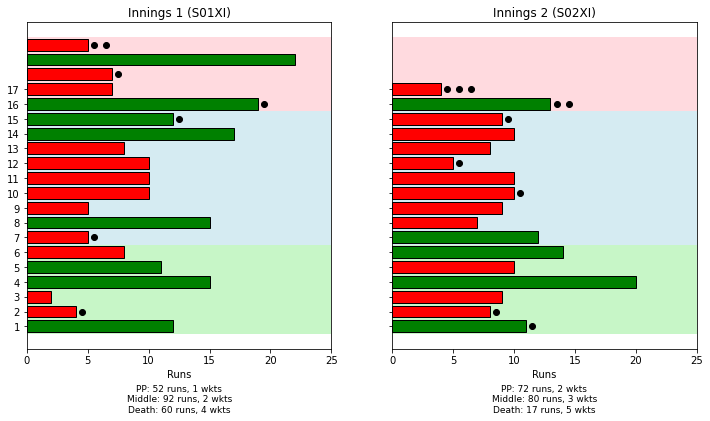

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df = runs_wkts_overs[runs_wkts_overs['match_id']==match]

overs1 = df[df['innings']==1]['over']
runs1 = df[df['innings']==1]['total_runs']
wkts1 = df[df['innings']==1]['isWicket']
team1 = df[df['innings']==1]['batting_team'].unique()[0]

rr = 6*df['total_runs'].sum()/df['islegal'].sum()

overs2 = df[df['innings']==2]['over']
runs2 = df[df['innings']==2]['total_runs']
wkts2 = df[df['innings']==2]['isWicket']
team2 = df[df['innings']==2]['batting_team'].unique()[0]

xmin = min(min(runs1), min(runs2))
xmax = max(max(runs1), max(runs2))

wkt_max = max(max(wkts1),max(wkts2))


summary1 = summarize_phases(overs1, runs1, wkts1)
summary2 = summarize_phases(overs2, runs2, wkts2)

# Format footnote text
def make_summary_text(summary):
    return "\n".join([
        f"{phase}: {data['runs']} runs, {data['wkts']} wkts"
        for phase, data in summary.items()
    ])

text1 = make_summary_text(summary1)
text2 = make_summary_text(summary2)


# Plotting
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)


plot_innings(axes[0], overs1, runs1, wkts1, f"Innings 1 ({team1})", threshold=rr)
plot_innings(axes[1], overs2, runs2, wkts2, f"Innings 2 ({team2})", threshold=rr)

# Add footnote text below each chart
axes[0].text(0.5, -0.2, text1, transform=axes[0].transAxes,
             fontsize=9, ha='center', va='bottom', linespacing=1.2)

axes[1].text(0.5, -0.2, text2, transform=axes[1].transAxes,
             fontsize=9, ha='center', va='bottom', linespacing=1.2)


#plt.tight_layout()
plt.savefig(f'/Users/roumyadas/Desktop/IPL_Simulation/Season_03/plots/run_charts/{match}.jpg', 
        format='jpg', dpi=300, bbox_inches='tight')

plt.show()

FIRST INNING SCORE:
RUNS: 204
WICKETS: 7
BALLS BOWLED: 120


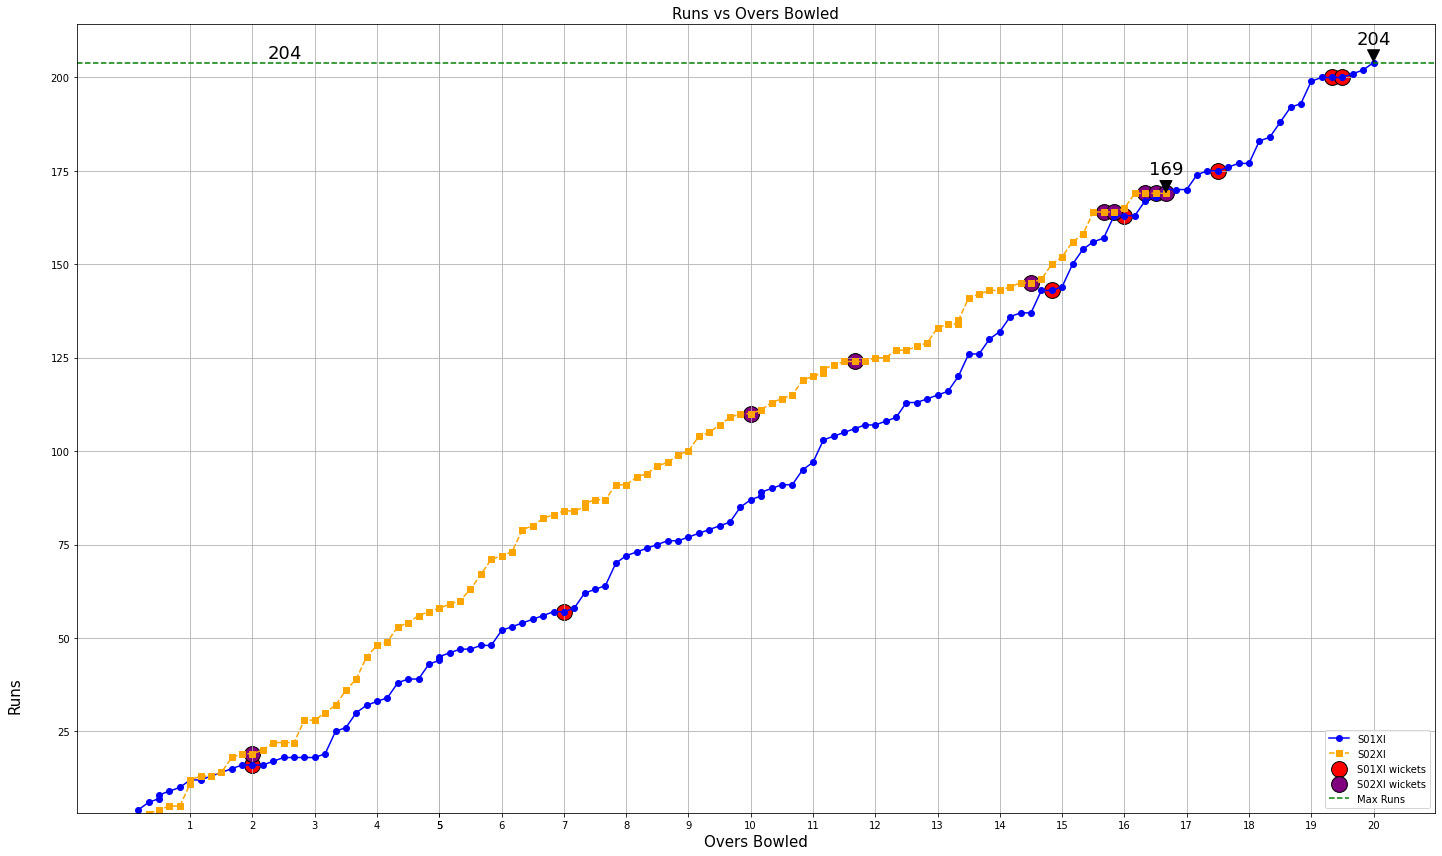

SECOND INNING SCORE:
RUNS: 169
WICKETS: 10
BALLS BOWLED: 100


In [357]:
live_score = df_all[df_all.match_id==m_id][df_all.innings==1].reset_index(drop=True)
df_other = df_all[df_all.match_id==m_id][df_all.innings==2].reset_index(drop=True)

bat_first = live_score['batting_team'].unique()[0]
bat_second = df_other['batting_team'].unique()[0]

print('FIRST INNING SCORE:')
print('RUNS:', live_score['runs_scored'].max())
print('WICKETS:', live_score['wickets_down'].max())
print('BALLS BOWLED:', live_score['legal_balls_bowled'].max())


# Assuming you have already imported your dataframe as 'live_score'

# Step 1: Remove duplicate rows based on 'predicted_runs' and 'legal_balls_bowled'
#live_score = live_score[live_score.legal_balls_bowled>=18]
live_score_unique = live_score.drop_duplicates(subset=['runs_scored', 'legal_balls_bowled'], keep='first')
df_other_unique = df_other.drop_duplicates(subset=['runs_scored', 'legal_balls_bowled'], keep='first')


#live_score_unique = live_score_unique[live_score_unique.legal_balls_bowled<=108]

# Calculate the minimum and maximum values for y-axis
min_y_limit = min(100, live_score_unique['runs_scored'].min() * 0.8)
max_y_limit = max(live_score_unique['runs_scored'].max() * 1.05, 200)

# Calculate the x-axis values by dividing 'legal_balls_bowled' by 6
x_values = live_score_unique['legal_balls_bowled'] / 6

# Calculate the x-axis values for the second line
x_values_other = df_other_unique['legal_balls_bowled'] / 6

# Plot the visualization
plt.figure(figsize=(20, 12))  # Set plot size to (15, 9)

# Add grey shade to background
#plt.fill_between(x_values, 0, 250, color='lightgrey')

plt.plot(x_values, live_score_unique['runs_scored'], marker='o', linestyle='-', color='b', 
         label=bat_first)
# Plot the second line (df_other_unique)
plt.plot(x_values_other, df_other_unique['runs_scored'], marker='s', linestyle='--', color='orange', 
         label=bat_second)


# Add red dot for wicket
wicket_indices = live_score_unique[live_score_unique['isWicket'] == 1].index
plt.scatter(x_values[wicket_indices], 
            live_score_unique.loc[wicket_indices, 'runs_scored'], 
            color='r', s=250, marker='o', edgecolors='black', label=str(bat_first)+' wickets')

# Adding wicket markers for the second line
wicket_indices_other = df_other_unique[df_other_unique['isWicket'] == 1].index
plt.scatter(x_values_other[wicket_indices_other], 
            df_other_unique.loc[wicket_indices_other, 'runs_scored'], 
            color='purple', s=250, marker='o', edgecolors='black', label=str(bat_second)+' wickets')

# Annotate the last data point of the second line
last_index_other = df_other_unique.index[-1]
last_x_other = x_values_other.iloc[-1]
last_y_other = np.round(df_other_unique['runs_scored'].iloc[-1], 2)
plt.annotate(f'{last_y_other}', xy=(last_x_other, last_y_other), xytext=(last_x_other, last_y_other + 5), fontsize=18,
             arrowprops=dict(facecolor='black', shrink=0.05), xycoords='data', ha='center')


plt.ylim(min_y_limit, max_y_limit)  # Set y-axis range
plt.title('Runs vs Overs Bowled', fontsize=15)  # Updated title
plt.xlabel('Overs Bowled',  fontsize=15)  # Updated x-axis label
plt.ylabel('Runs', va='bottom',  fontsize=15)  # Updated y-axis label
plt.grid(True)

# Set x-axis ticks to display only integer values
plt.xticks(x_values[x_values.apply(lambda x: x.is_integer())])

# Annotate the last data point with its y-axis value just above the end of the line
last_index = live_score_unique.index[-1]
last_x = x_values.iloc[-1]
last_y = np.round(live_score_unique['runs_scored'].iloc[-1], 2)
plt.annotate(f'{last_y}', xy=(last_x, last_y), xytext=(last_x, last_y + 5), fontsize=18,
             arrowprops=dict(facecolor='black', shrink=0.05), xycoords='data', ha='center')

# Plot reference lines for highest and lowest predicted runs achieved
plt.axhline(y=live_score_unique['runs_scored'].max(), color='g', linestyle='--', label='Max Runs')

# Annotate the values of the reference lines on the y-axis
plt.text(2.8, live_score_unique['runs_scored'].max(), f'{int(live_score_unique["runs_scored"].max())}',  va='bottom', ha='right', fontsize=18)#
#plt.text(2.8, live_score_unique['runs_scored'].min(), f'{live_score_unique["runs_scored"].min():.2f}',  va='top', ha='right', fontsize=18) #

plt.legend()  # Show legend

# Adjust the position of y-label to the bottom
plt.gca().yaxis.set_label_coords( -0.04, 0.15)

plt.tight_layout()
plt.savefig(f'/Users/roumyadas/Desktop/IPL_Simulation/Season_03/plots/score_worms/{m_id}.jpg', 
            format='jpg', dpi=300, bbox_inches='tight')
plt.show()

print('SECOND INNING SCORE:')
print('RUNS:', df_other['runs_scored'].max())
print('WICKETS:', df_other['wickets_down'].max())
print('BALLS BOWLED:', df_other['legal_balls_bowled'].max())

## run-rate chart

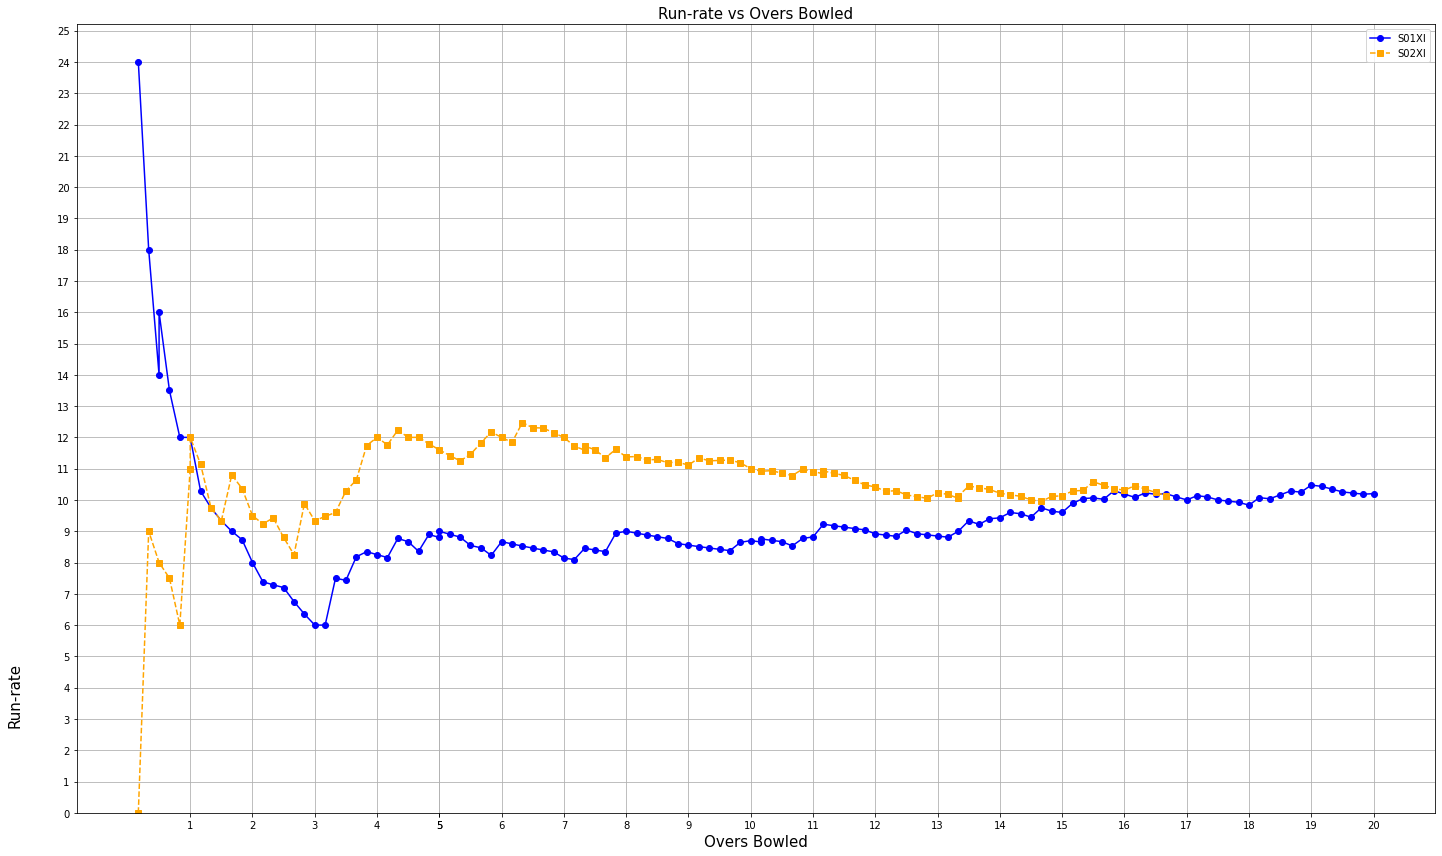

In [358]:
live_score = df_all[df_all.match_id==m_id][df_all.innings==1].reset_index(drop=True)
df_other = df_all[df_all.match_id==m_id][df_all.innings==2].reset_index(drop=True)

bat_first = live_score['batting_team'].unique()[0]
bat_second = df_other['batting_team'].unique()[0]

live_score_unique = live_score.drop_duplicates(subset=['runs_scored', 'legal_balls_bowled'], keep='first')
df_other_unique = df_other.drop_duplicates(subset=['runs_scored', 'legal_balls_bowled'], keep='first')

min_y_limit = min(100, live_score_unique['run_rate'].min() * 0.8, 0)
max_y_limit = max(live_score_unique['run_rate'].max() * 1.05,df_other_unique['run_rate'].max() * 1.05)

# Calculate the x-axis values by dividing 'legal_balls_bowled' by 6
x_values = live_score_unique['legal_balls_bowled'] / 6

# Calculate the x-axis values for the second line
x_values_other = df_other_unique['legal_balls_bowled'] / 6

# Plot the visualization
plt.figure(figsize=(20, 12))  # Set plot size to (15, 9)

# Add grey shade to background
#plt.fill_between(x_values, 0, 250, color='lightgrey')

plt.plot(x_values, live_score_unique['run_rate'], marker='o', linestyle='-', color='b', 
         label=bat_first)
# Plot the second line (df_other_unique)
plt.plot(x_values_other, df_other_unique['run_rate'], marker='s', linestyle='--', color='orange', 
         label=bat_second)


plt.ylim(min_y_limit, max_y_limit)  # Set y-axis range
plt.title('Run-rate vs Overs Bowled', fontsize=15)  # Updated title
plt.xlabel('Overs Bowled',  fontsize=15)  # Updated x-axis label
plt.ylabel('Run-rate', va='bottom',  fontsize=15)  # Updated y-axis label
plt.grid(True)

#set axis ticks
plt.xticks(x_values[x_values.apply(lambda x: x.is_integer())])
plt.yticks(range(int(max_y_limit)+1))

plt.legend()  # Show legend

# Adjust the position of y-label to the bottom
plt.gca().yaxis.set_label_coords( -0.04, 0.15)

plt.tight_layout()
plt.savefig(f'/Users/roumyadas/Desktop/IPL_Simulation/Season_03/plots/run_rate/{m_id}.jpg', 
            format='jpg', dpi=300, bbox_inches='tight')
plt.show()


## partnership-barchart plot

In [359]:
match = 'S03M001'

In [360]:
import matplotlib.pyplot as plt
import seaborn as sns
df_sim = df_all[df_all.match_id==match]

#samp = df_sim[df_sim.match_id=='M072']

df_sim['before_ball_partnership'] = 0
df_sim['after_ball_partnership'] = 0
df_sim['before_balls'] = 0
df_sim['after_balls'] = 0

for m_id in df_sim.match_id.unique():
    #print(m_id)
    bp = 0
    ap = 0
    bb = 0
    ab = 0
    for inn in df_sim[df_sim.match_id==m_id].innings.unique():
        bp = 0
        ap = 0
        bb = 0
        ab = 0
        for index,row in df_sim[df_sim.match_id==m_id][df_sim.innings==inn].iterrows():
            ap = bp + row['total_runs']
            ab = bb + row['is_faced_by_batter']
            #print(ap,bp)
            df_sim.at[index, 'before_ball_partnership'] = bp
            df_sim.at[index, 'after_ball_partnership'] = ap
            df_sim.at[index, 'before_balls'] = bb
            df_sim.at[index, 'after_balls'] = ab
            bp = ap
            bb = ab
            if row['isWicket']==1:
                bp = 0
                ap = 0
                bb = 0
                ab = 0
        


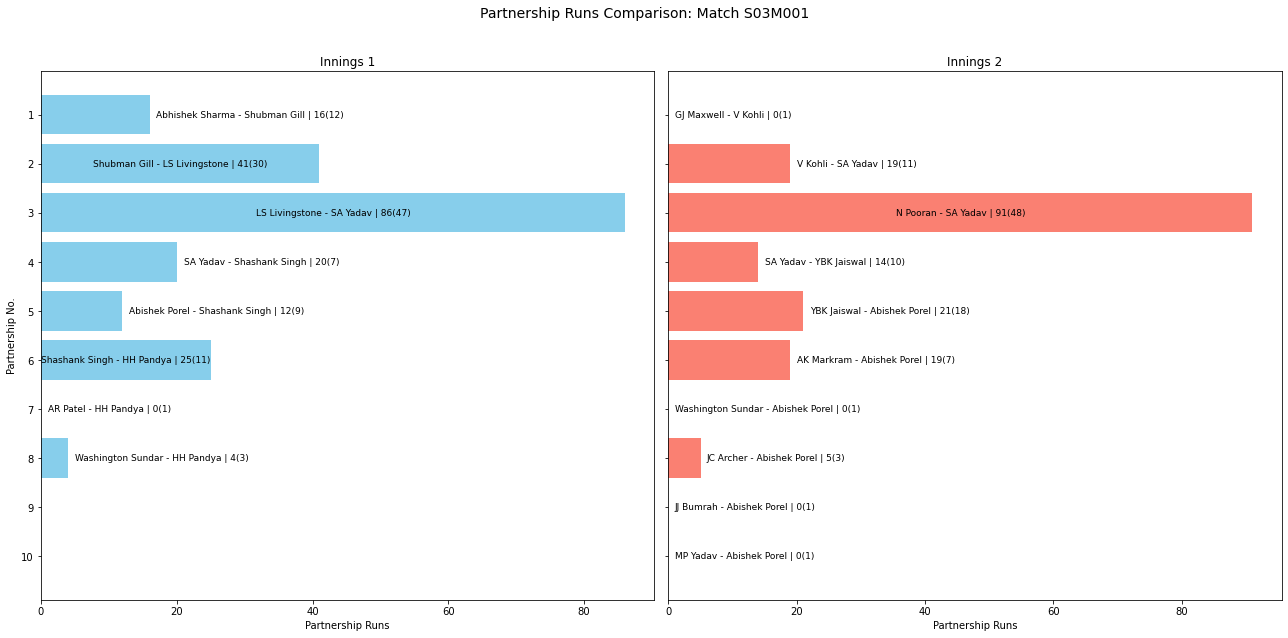

In [361]:
# Step 1: Sort for tail extraction
df_sim = df_sim.sort_values(['match_id', 'innings', 'legal_balls_bowled'])

# Step 2: Get last ball of each innings
last_partnerships = df_sim.groupby(['match_id', 'innings']).tail(1)

# Step 3: Get wicket-end partnerships
wicket_partnerships = df_sim[df_sim['isWicket'] == 1]

# Step 4: Combine and deduplicate
partnership_df = pd.concat([wicket_partnerships, last_partnerships], ignore_index=True)
partnership_df = partnership_df.drop_duplicates(subset=['match_id', 'innings', 'legal_balls_bowled'])

# Step 5: Add partnership number within each innings
partnership_df['partnership_no'] = (
    partnership_df.groupby(['match_id', 'innings']).cumcount() + 1
)

# Step 6: Prepare label columns
partnership_df['runs_balls'] = (
    partnership_df['after_ball_partnership'].astype(str) + 
    '(' + partnership_df['after_balls'].astype(str) + ')'
)

# Plot dataframe
plot_df = partnership_df.copy()

# Step 7: Split by innings
innings1_df = plot_df[plot_df['innings'] == 1].copy()
innings2_df = plot_df[plot_df['innings'] == 2].copy()

# Sort descending so lower partnerships are at the bottom
innings1_df = innings1_df.sort_values(by='partnership_no', ascending=False)
innings2_df = innings2_df.sort_values(by='partnership_no', ascending=False)

# Step 8: Plotting
fig, axes = plt.subplots(ncols=2, figsize=(18, max(len(plot_df)//2, 5)), sharey=True)

# Innings 1
axes[0].barh(
    y=innings1_df['partnership_no'],
    width=innings1_df['after_ball_partnership'],
    color='skyblue'
)

p_max1 = innings1_df['after_ball_partnership'].max()

for _, row in innings1_df.iterrows():
    runs = row['after_ball_partnership']
    label = f"{row['striker']} - {row['non_striker']} | {row['runs_balls']}"
    
    if runs < max(20, int(p_max1/4)):
        # too short, put label to the right of the bar
        x_pos = runs + 1
        ha = 'left'
    else:
        x_pos = runs / 2
        ha = 'center'
    
    axes[0].text(
        x_pos, row['partnership_no'],
        label,
        va='center', ha=ha, fontsize=9, color='black'
    )

axes[0].set_title("Innings 1")
axes[0].set_xlabel("Partnership Runs")
axes[0].invert_yaxis()
axes[0].set_ylabel("Partnership No.")

# Innings 2
axes[1].barh(
    y=innings2_df['partnership_no'],
    width=innings2_df['after_ball_partnership'],
    color='salmon'
)

p_max2 = innings2_df['after_ball_partnership'].max()

for _, row in innings2_df.iterrows():
    runs = row['after_ball_partnership']
    label = f"{row['striker']} - {row['non_striker']} | {row['runs_balls']}"
    
    if runs < max(20, int(p_max2/4)):
        x_pos = runs + 1
        ha = 'left'
    else:
        x_pos = runs / 2
        ha = 'center'
    
    axes[1].text(
        x_pos, row['partnership_no'],
        label,
        va='center', ha=ha, fontsize=9, color='black'
    )
    
max_partnership_no = max(
    innings1_df['partnership_no'].max() if not innings1_df.empty else 0,
    innings2_df['partnership_no'].max() if not innings2_df.empty else 0
)

axes[0].set_yticks(range(1, max_partnership_no + 1))
axes[1].set_yticks(range(1, max_partnership_no + 1))


axes[1].set_title("Innings 2")
axes[1].set_xlabel("Partnership Runs")

# Common title
plt.suptitle(f'Partnership Runs Comparison: Match {plot_df["match_id"].iloc[0]}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'/Users/roumyadas/Desktop/IPL_Simulation/Season_03/plots/partnership/{m_id}.jpg', 
            format='jpg')

plt.show()
